In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import matthews_corrcoef,confusion_matrix, make_scorer
mcc_scorer = make_scorer(matthews_corrcoef)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


# Testing the Stability of tRFs Across Time

## Introduction
This report outlines the testing of the hypothesis that tRNA-derived fragments (tRFs) are stable over time, forming a unique "fingerprint" for each individual. The analysis involves the use of multiple classifiers to identify the most effective model in distinguishing individuals based on their tRF profiles.

## Methods
### Data Preparation
- **Dataset:** Two CSV files were used: 'PPMI_subjects.csv' and 'tRF_counts.csv'.
- **Selection:** The top 0.5% of enriched tRFs were selected, resulting in 253 tRFs for analysis.
- **Split:** Data was divided into training and test sets, with the test set containing the last samples of each subject.
- **Scaling:** Features were scaled using StandardScaler.

## Model Training and Evaluation
A MultiClassModel class was implemented to train and evaluate multiple classifiers, including:

- XGBoost
- HistGradientBoostingClassifier
- RandomForestClassifier
- SVC (linear and non-linear)
- KNeighborsClassifier
- GaussianNB
- OneVsRest LogisticRegression

### Evaluation Metric: 
The main evaluation metric used was the Matthews Correlation Coefficient (MCC), a robust measure of the quality of binary and multiclass classifications.

### Model Tuning
The best-performing classifier was tuned using GridSearchCV with predefined parameter grids, optimizing for the MCC score.

### Comparison with Dummy Model
The best classifier was compared against a dummy model trained on shuffled labels to ensure that the model's performance was not due to random chance.

In [68]:

# Define the MultiClassModel class
class MultiClassModel:
    def __init__(self, num_classes, classifiers=None):
        self.num_classes = num_classes
        self.classifiers = classifiers if classifiers else {
            'XGBoost': XGBClassifier(objective='multi:softmax', num_class=num_classes, eval_metric='mlogloss'),
            'HGBoost': HistGradientBoostingClassifier(),
            'RandomForest': RandomForestClassifier(),
            'LinearSVC': SVC(probability=True, kernel='linear'),
            'SVC': SVC(probability=True),
            'KNN': KNeighborsClassifier(),
            'NaiveBayes': GaussianNB(),
            'LogisticRegression': OneVsRestClassifier(LogisticRegression(max_iter=10000))
        }
        self.best_clf = None
        self.best_classifier = None
        self.best_f1 = 0
        self.comparison = {}
        self.models = {}

    def fit_classifiers(self, X_train, y_train, X_test, y_test):

        for name, clf in self.classifiers.items():
            clf.fit(X_train, y_train)
            score = self.evaluate(y_test,clf.predict(X_test),name)
            self.models[name] = {'clf': clf} 
            self.comparison[name] = {'mcc': score}
            if score > self.best_f1:
                self.best_f1 = score
                self.best_classifier  = name
        
        print(f"\nBest Classifier: {self.best_classifier } with Mean F1 Score: {self.best_f1:.4f}")
        
        # Fit the best classifier on the entire training set
        self.best_clf = self.classifiers[self.best_classifier]
        self.best_clf.fit(X_train, y_train)
        
        return self.comparison, self.best_classifier

    def tune_classifier(self, X_train, y_train):
        param_grids = {
            'XGBoost': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]},
            'RandomForest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]},
            'SVC': {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
            'LinearSVC': {'C': [0.1, 1, 10, 100, 1000]},  # Parameter grid for linear SVC
            'KNN': {'n_neighbors': [3, 5, 7]},
            'LogisticRegression': {'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],'estimator__penalty': ['l2']},
            'HistGradientBoosting': {'learning_rate': [0.01, 0.1, 0.2], 'max_iter': [100, 200, 300]} 
        }

        if self.best_classifier is not None:
            if self.best_classifier in param_grids:
                rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5)
                grid_search = GridSearchCV(estimator=self.best_clf, param_grid=param_grids[self.best_classifier], cv=rskf, scoring=mcc_scorer, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                self.best_clf = grid_search.best_estimator_
                self.best_params = grid_search.best_params_
                print(f"Best parameters for {self.best_classifier}: {self.best_params}")
                # Refit the final model with the best parameters
                self.best_clf.fit(X_train, y_train)

    def predict(self, X_test):
        y_pred = self.best_clf.predict(X_test)
        return y_pred

    def predict_proba(self, X_test):
        if hasattr(self.best_clf, "predict_proba"):
            y_prob = self.best_clf.predict_proba(X_test)
            return y_prob
        else:
            raise AttributeError("The selected classifier does not support probability predictions.")

    def evaluate(self, y_test, y_pred, name):
        score = matthews_corrcoef(y_test, y_pred)
        print(f'{name} Test matthews corr coef score: {score:.4f}')
        return score

# Data Preparation
percent_enriched = 0.005
PPMI = pd.read_csv('PPMI_subjects.csv')
tRF = pd.read_csv('tRF_counts.csv', index_col=0).T
PPMI = PPMI.set_index('sample')
PPMI = PPMI.sort_values(['sbj','Months_from_BL'])

test_ix = PPMI.index.isin(PPMI.drop_duplicates(subset='sbj',keep='last').index)
train_ix = ~test_ix

selected_tRFs = tRF.columns[tRF.sum() > tRF.sum().quantile(1 - percent_enriched)]
print(f'Using top {percent_enriched*100:.2}% Enriched tRFs for a total of {selected_tRFs.shape[0]} tRFs')
y = PPMI.sbj.astype('category').cat.codes
X =  tRF[selected_tRFs].astype(float)

y_train,y_test = y[train_ix],y[test_ix]
X_train,X_test = X[train_ix],X[test_ix]

train_shuffle_idx = np.random.permutation(len(X_train))
X_train = X_train.iloc[train_shuffle_idx]
y_train = y_train.iloc[train_shuffle_idx]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Initialize the model
model = MultiClassModel(num_classes=len(y_train.unique()))

# Step 1: Fit and Evaluate Classifiers
print("Fitting and Evaluating Classifiers:")
results, best_classifier = model.fit_classifiers(X_train_scaled, y_train, X_test_scaled, y_test)


# Step 2: Tune the Best Classifier
print("\nTuning the Best Classifier:")
model.tune_classifier(X_train_scaled, y_train)

# Step 3: Predict and Evaluate
print("\nEvaluating the Tuned Classifier:")
y_pred = model.predict(X_test_scaled)
model.evaluate(y_test, y_pred, best_classifier)

# Step 4: Compare with a Dummy Model
print("\nComparing with the best Model trained on shuffled labels (Random Prediction):")
dummy_shuffle_idx = np.random.permutation(len(y_train))
dummy_clf = model.classifiers[model.best_classifier]
dummy_clf.fit(X_train_scaled, y_train.iloc[dummy_shuffle_idx].values)
y_dummy_pred = dummy_clf.predict(X_test_scaled)
print("\nEvaluating the Dummy Model:")
dummy_accuracy = matthews_corrcoef(y_test.values, y_dummy_pred)
print(f'Dummy Model Test MCC Score: {dummy_accuracy:.8f}')


Using top 0.5% Enriched tRFs for a total of 253 tRFs
Fitting and Evaluating Classifiers:
XGBoost Test matthews corr coef score: 0.3381
HGBoost Test matthews corr coef score: 0.2243
RandomForest Test matthews corr coef score: 0.3286
LinearSVC Test matthews corr coef score: 0.4361
SVC Test matthews corr coef score: 0.2943
KNN Test matthews corr coef score: 0.2089
NaiveBayes Test matthews corr coef score: 0.0658
LogisticRegression Test matthews corr coef score: 0.7483

Best Classifier: LogisticRegression with Mean F1 Score: 0.7483

Tuning the Best Classifier:
Best parameters for LogisticRegression: {'estimator__C': 1000, 'estimator__penalty': 'l2'}

Evaluating the Tuned Classifier:
LogisticRegression Test matthews corr coef score: 0.7608

Comparing with the best Model trained on shuffled labels (Random Prediction):

Evaluating the Dummy Model:
Dummy Model Test MCC Score: -0.00316057


<Axes: >

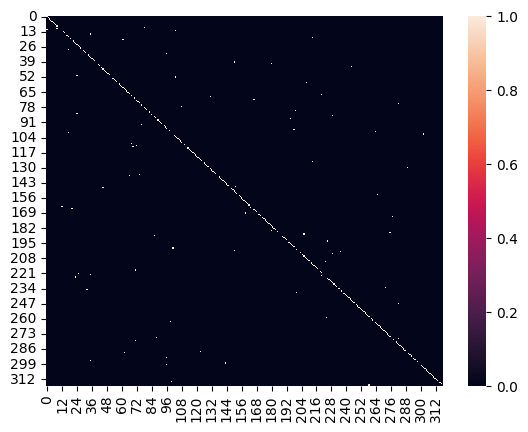

In [69]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm))

In [73]:
# Extract the coefficients from the logistic regression model
coefficients = [estimator.coef_[0] for estimator in model.best_clf.estimators_]

# # Sort the coefficients by their absolute values
# sorted_indices = np.argsort(np.abs(coefficients))[::-1]
# sorted_features = features[sorted_indices]
# sorted_coefficients = coefficients[sorted_indices]

# # Plot the top 20 features
# plt.figure(figsize=(4, 10))
# plt.barh(sorted_features[:50], sorted_coefficients[:50], color='blue')
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.title('Top 50 Features by Coefficient Value')
# plt.gca().invert_yaxis()
# plt.show()